In [3]:
%pip install joblib numpy pandas matplotlib scikit-learn pybaselines

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Импортирование библиотек

In [157]:
import warnings
import joblib
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib as mpl
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import normalize
from pybaselines import Baseline

mpl.style.use("ggplot")
pylab.rcParams["figure.figsize"] = 12, 8
%matplotlib inline
warnings.filterwarnings("ignore")


#### Путь к модели с весами .cbm и к данным .txt

In [120]:
PATH_TO_MODEL = "rf_w_500_norm_snip40_test.joblib"
PATH_TO_DATA = "image_peritumor_patient25022020_633.txt"
# PATH_TO_DATA = "data/image_tumor_patient25022020_633nm_obj20_power100_1sec_сenter2900_step4um_place1_20200925_1 (копия).txt"
# PATH_TO_DATA = "data/image_cortex_patient15012020_633nm_obj20_power100_1sec_acc1_сenter2900_place2_dots20x15_10um_20210202.txt"

#### Загрузка данных

In [121]:
df = pd.read_csv(
    PATH_TO_DATA,
    sep="\t",
    skiprows=[0],
    header=None,
    names=["X", "Y", "Wave", "Intensity"],
)

num_of_samples = int(len(df) / df["Wave"].nunique())
X = [
    df[["Intensity"]][
        i * df["Wave"].nunique():(i + 1) * df["Wave"].nunique()
    ].to_numpy()
    for i in range(num_of_samples)
]
X = np.asarray(X)
X = X.reshape(num_of_samples, df["Wave"].nunique())

print(f"Передано образцов: {num_of_samples}")

Передано образцов: 468


#### Предобработка

In [122]:
x_bc = list(range(1015))
baseline_fitter = Baseline(x_data=x_bc)

X_norm = normalize(X)

for i in range(len(X_norm)):
      X_norm[i] -= baseline_fitter.snip(X_norm[i], max_half_window=40,
                                                decreasing=False,
                                                smooth_half_window=3)[0]

#### Модель

In [123]:
# Загрузка модели из файла
model = joblib.load(PATH_TO_MODEL) 

# Использование загруженной модели
y_pred_proba = model.predict_proba(X_norm)
# Порог уверенности модели
diff = 0.2
y_pred = np.where(y_pred_proba[:, 1] > 0.5, 1, 0)
# обозначаем прогноз как 2 (вероятность принадлежности к классу > 0.4 и < 0.6)
y_pred[abs(y_pred_proba[:, 1]-y_pred_proba[:, 0]) < diff] = 2

#### Предсказания для переданных данных: 

0 - здоровый, 1 - больной, 2 - неопределенно

In [149]:
zeros = 0
ones = 0
for i in y_pred:
    if i == 0:
        zeros += 1
    elif i == 1:
        ones += 1
print(f'0: {zeros}/{num_of_samples}')
print(f'1: {ones}/{num_of_samples}')
print(f'2: {num_of_samples-ones-zeros}/{num_of_samples}')

0: 437/468
1: 0/468
2: 31/468


#### Вероятности для каждого предсказания

In [150]:
predictions_probs = model.predict_proba(X_norm)
print(predictions_probs[:20])

[[0.82508162 0.17491838]
 [0.872      0.128     ]
 [0.888      0.112     ]
 [0.854      0.146     ]
 [0.91       0.09      ]
 [0.88678142 0.11321858]
 [0.90556283 0.09443717]
 [0.91076224 0.08923776]
 [0.89354894 0.10645106]
 [0.8831176  0.1168824 ]
 [0.85399615 0.14600385]
 [0.894      0.106     ]
 [0.90155489 0.09844511]
 [0.888      0.112     ]
 [0.91       0.09      ]
 [0.906      0.094     ]
 [0.914      0.086     ]
 [0.90876025 0.09123975]
 [0.9087834  0.0912166 ]
 [0.88647717 0.11352283]]


#### Карта прогнозов для спектрограммы

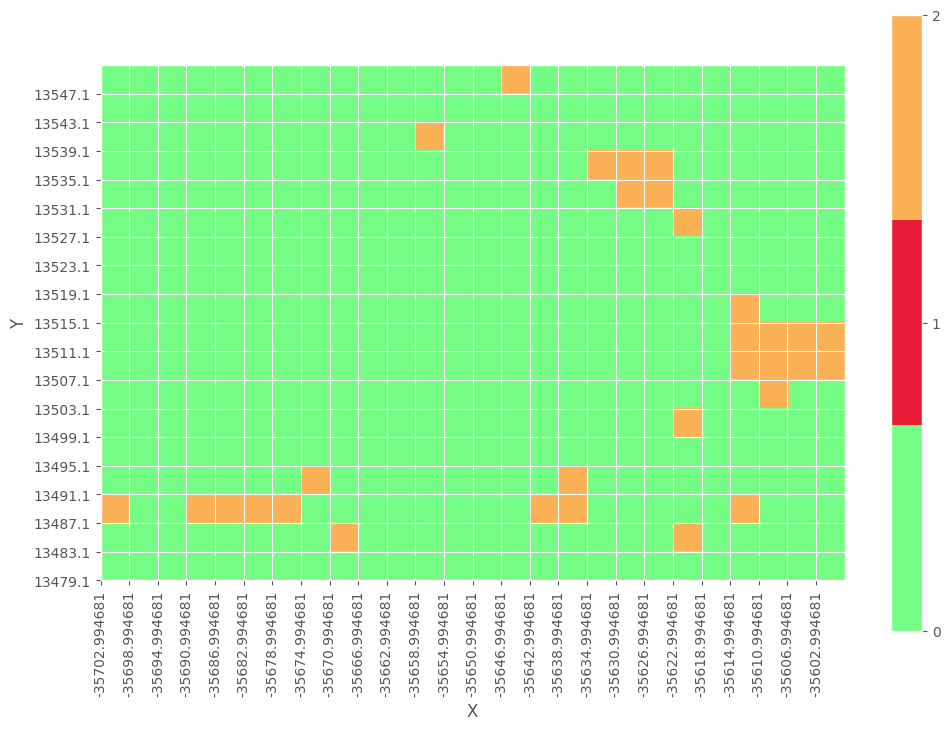

In [158]:
unique_x = df["X"].unique()
unique_y = df["Y"].unique()[::-1]

# Рассчитываем количество строк и столбцов матрицы:
n_rows = len(unique_y)
n_cols = len(unique_x)

# Создаем матрицу заполненную нулями:
matrix = np.zeros((n_rows, n_cols))

# Заполняем матрицу значениями из массива y_pred:
idx = 0
for i, y in enumerate(unique_y):
    for j, x in enumerate(unique_x):
        matrix[i, j] = y_pred[idx]
        idx += 1

matrix = np.flipud(matrix)
colors = ["#74fc84", "#e81c37", "#fab055"]
cmap = ListedColormap(colors)

# Отображаем матрицу как тепловую карту:
fig, ax = plt.subplots()
im = ax.imshow(matrix, cmap=cmap)

ax.set_xticks(np.arange(n_cols) - 0.5)
ax.set_yticks(np.arange(n_rows) + 0.5)

plt.xticks(rotation=90)

ax.set_xticklabels(unique_x)
ax.set_yticklabels(unique_y)
ax.set_xlabel("X")
ax.set_ylabel("Y")
cbar = ax.figure.colorbar(im, ax=ax, ticks=[0, 1, 2])
cbar.ax.set_yticklabels(["0", "1", "2"])

plt.show()


#### График и предсказание для каждого образца

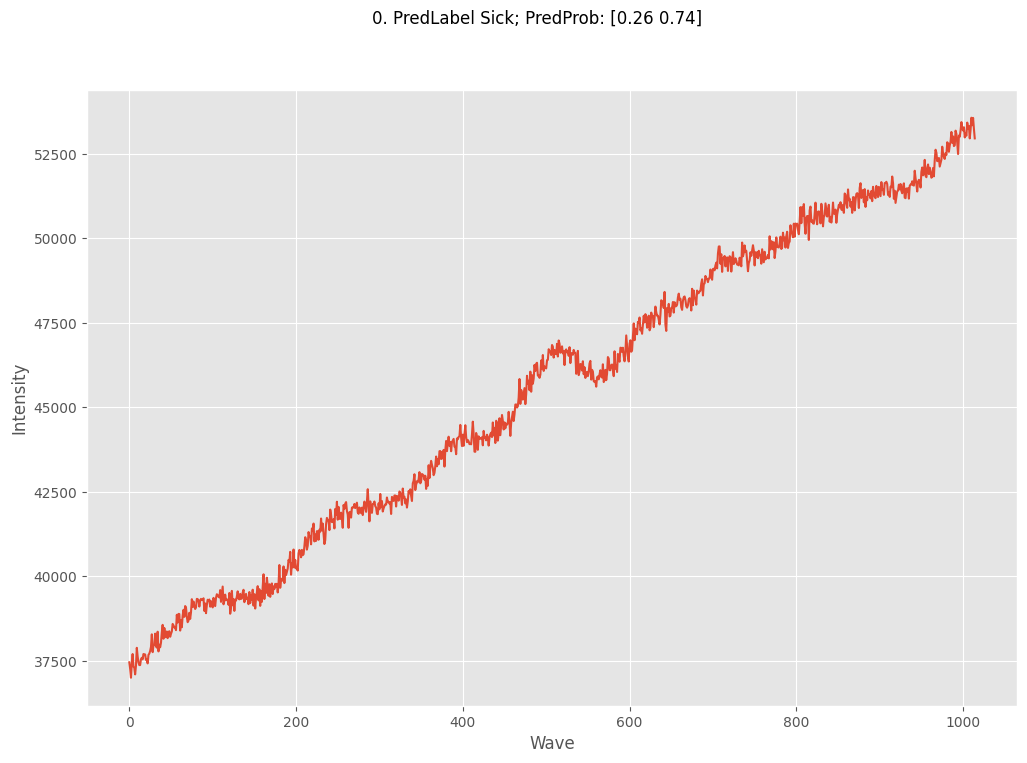

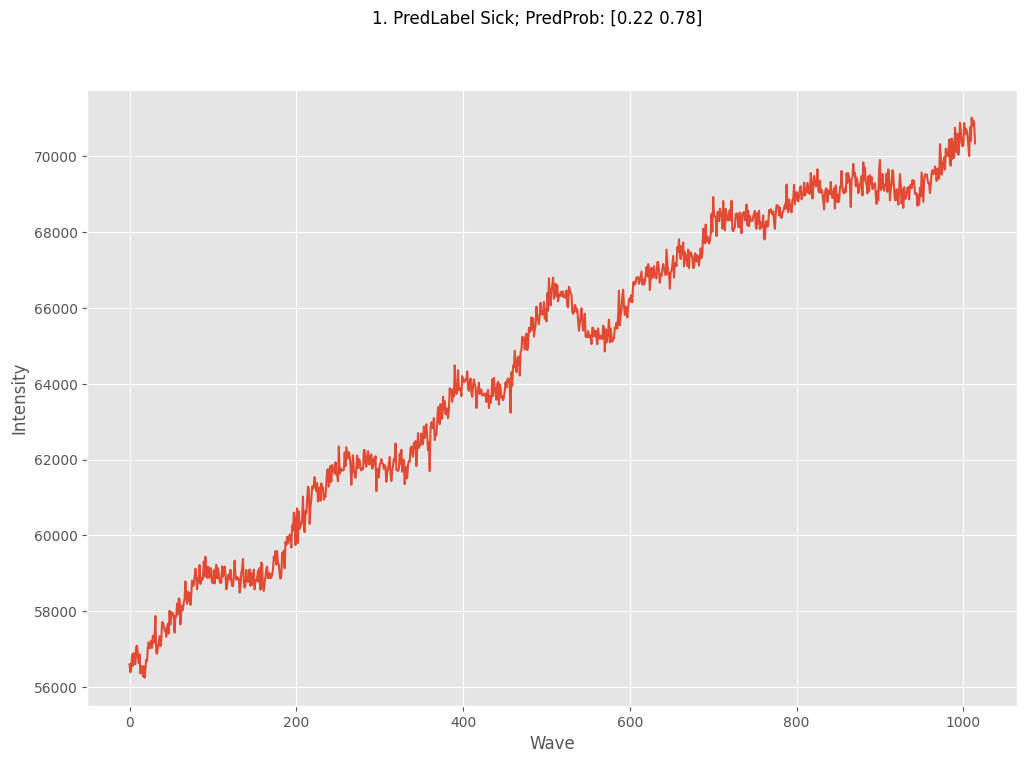

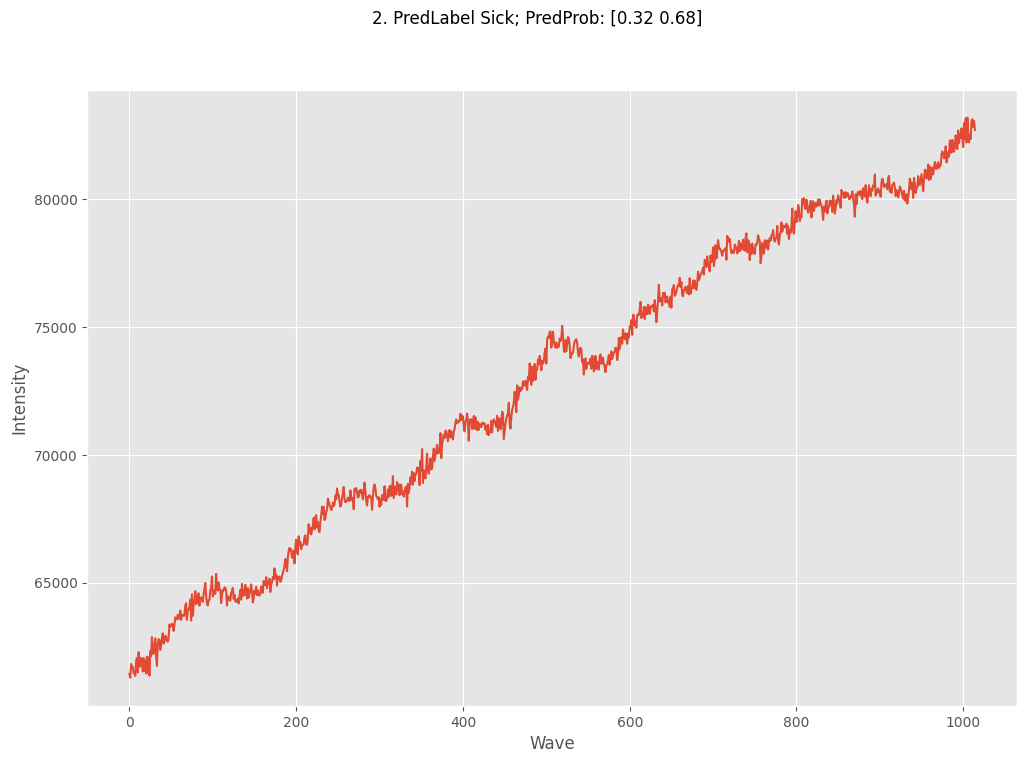

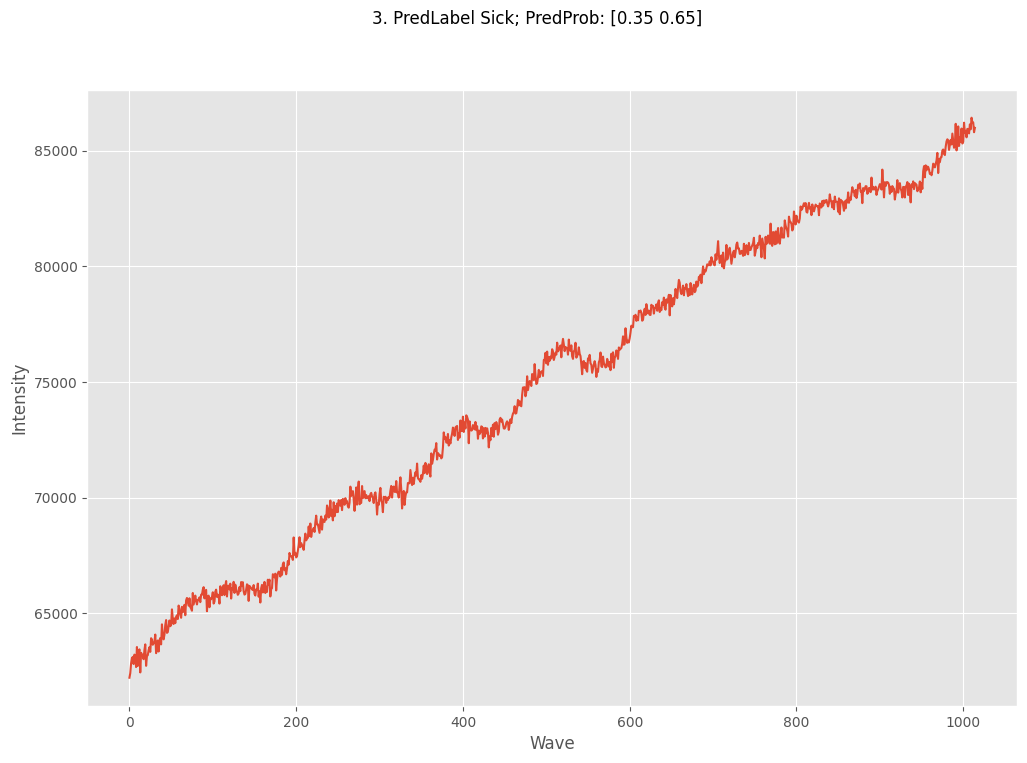

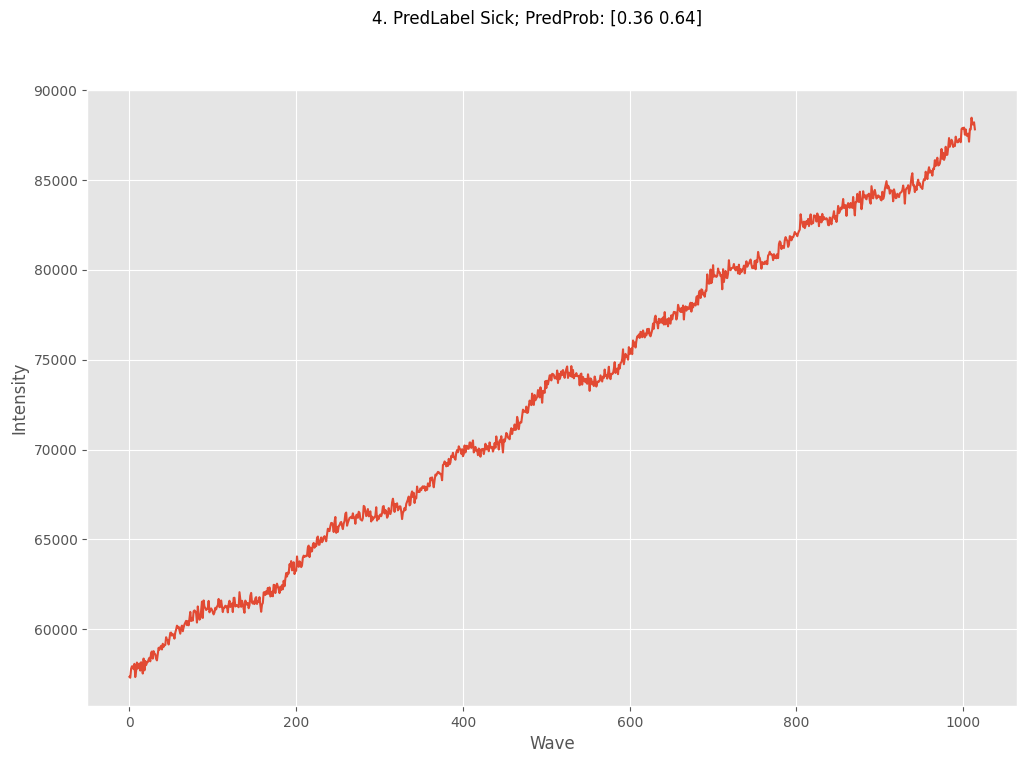

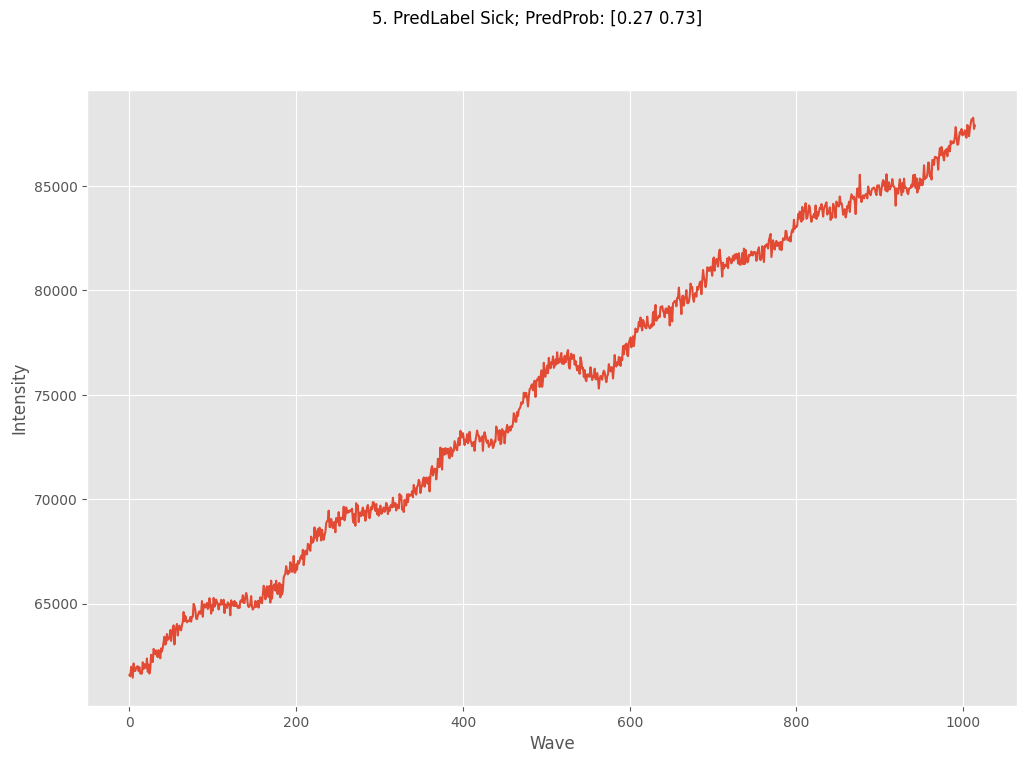

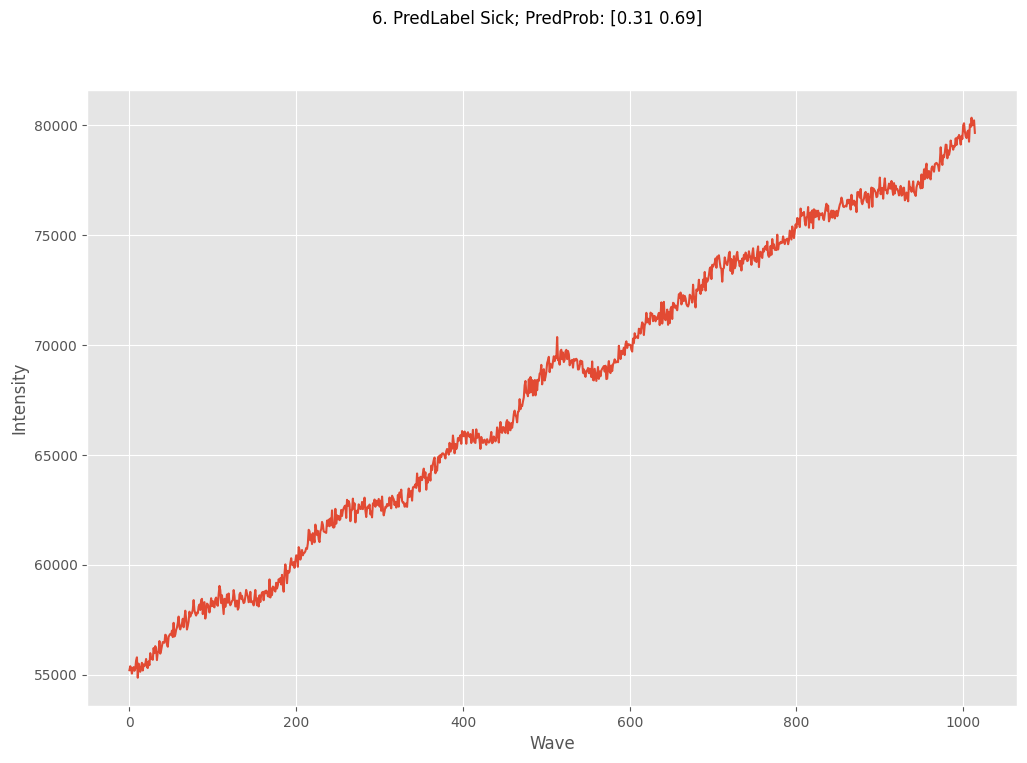

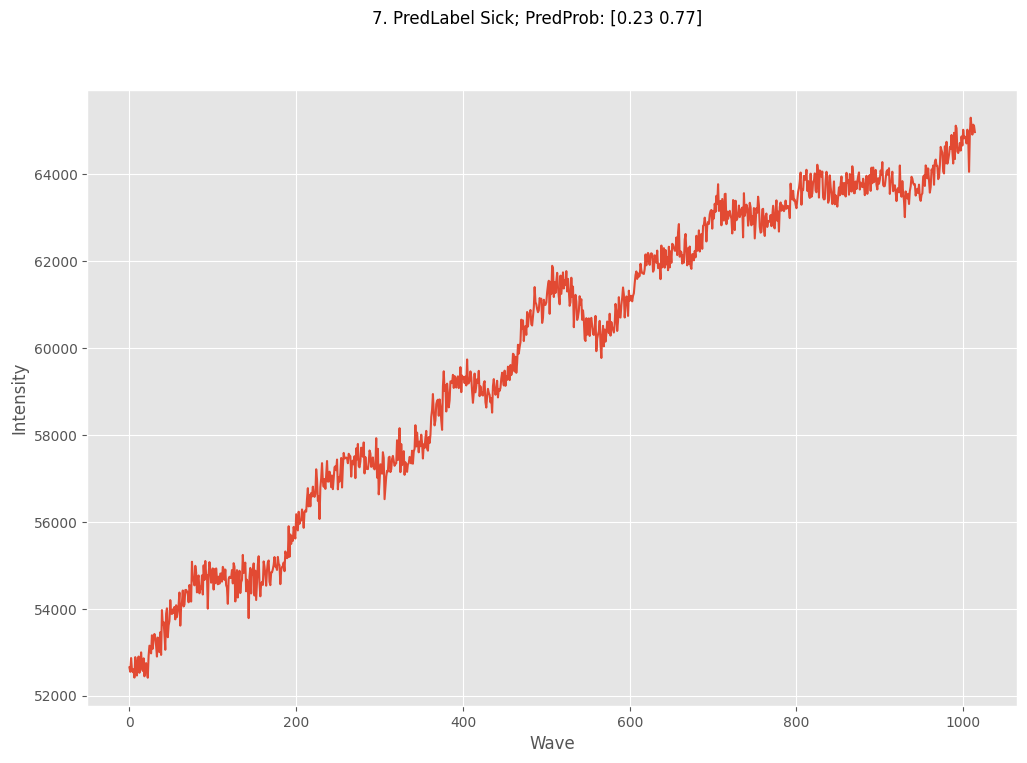

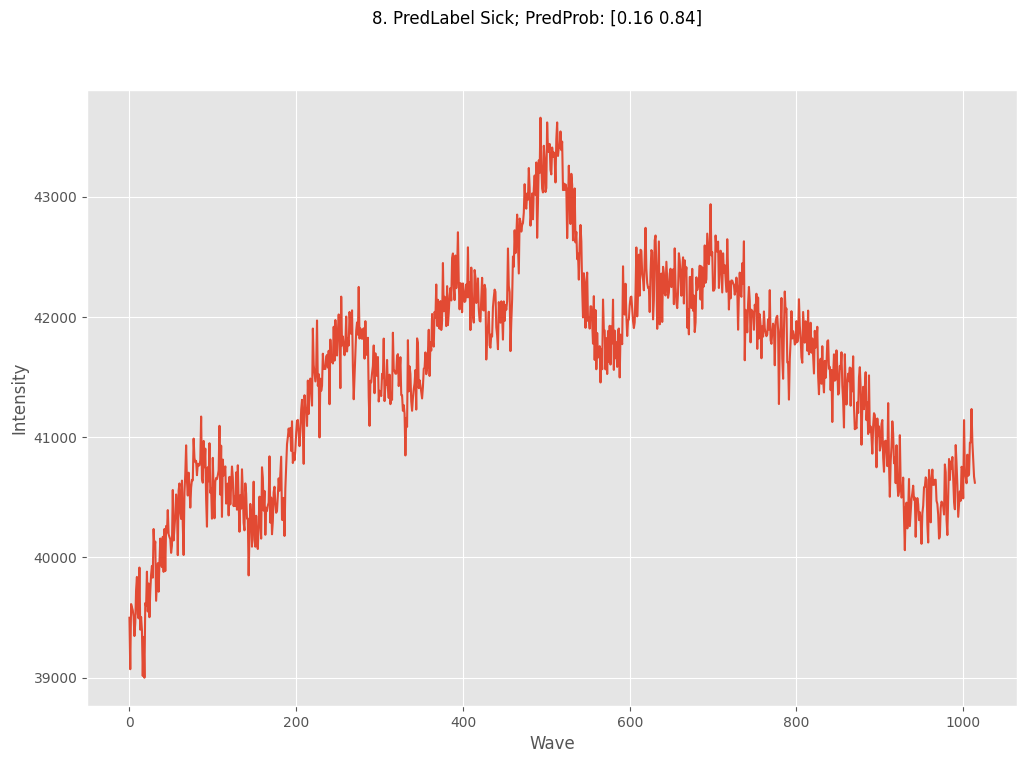

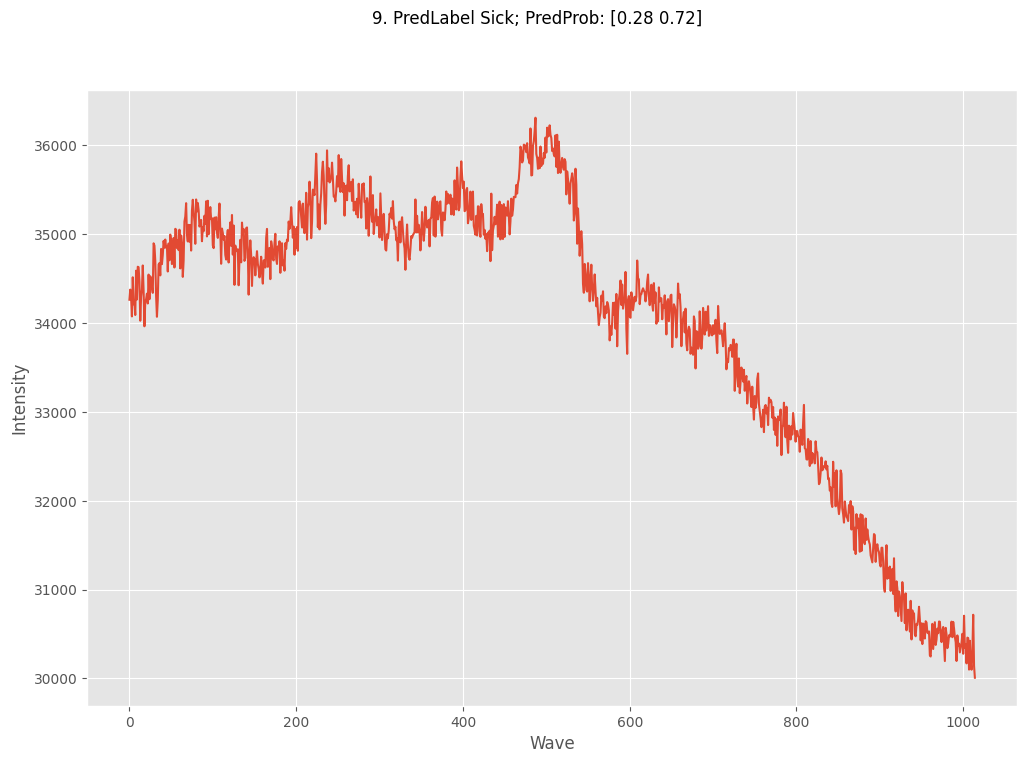

In [ ]:
pred = model.predict_proba(X_norm)
y_pred = model.predict(X_norm)

for i in range(10):
    pred_label = "Sick"
    if y_pred[i] == 0: pred_label = "Healthy"
    elif y_pred[i] == 2: pred_label = "Uncertain"
    fig, ax1 = plt.subplots(1, 1)
    fig.suptitle(f'{i}. PredLabel {pred_label}; PredProb: {np.round(pred,2)[i]}')
    ax1.plot(X[i])
    ax1.set_ylabel('Intensity')
    ax1.set_xlabel('Wave')

    plt.show()

#### Сохранение предсказаний в txt file

In [ ]:
# В формате label
output_file = f"labels_{datetime.now().strftime('%d_%m_%Y_%H_%M_%S')}.txt"
with open(output_file, "w") as outfile:
    for i in range(num_of_samples):
        outfile.write(f"{y_pred[i]}\n")

In [ ]:
# В формате id label
output_file = f"labels_{datetime.now().strftime('%d_%m_%Y_%H_%M_%S')}.txt"
with open(output_file, "w") as outfile:
    for i in range(num_of_samples):
        outfile.write(f"{i} {y_pred[i]}\n")

In [ ]:
# В формате X Y label
output_file = f"labels_{datetime.now().strftime('%d_%m_%Y_%H_%M_%S')}.txt"
with open(output_file, "w") as outfile:
    for i in range(num_of_samples):
        outfile.write(
            f"{df.iloc[i * df['Wave'].nunique()]['X']} "
            f"{df.iloc[i * df['Wave'].nunique()]['Y']} "
            f"{y_pred[i]}\n"
        )

In [156]:
# В формате id X Y label
output_file = f"labels_{datetime.now().strftime('%d_%m_%Y_%H_%M_%S')}.txt"
with open(output_file, "w") as outfile:
    for i in range(num_of_samples):
        outfile.write(
            f"{i} {df.iloc[i * df['Wave'].nunique()]['X']} "
            f"{df.iloc[i * df['Wave'].nunique()]['Y']} "
            f"{y_pred[i]}\n"
        )